In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import wandb
import numpy as np
import torch
import random
import itertools
from tqdm import tqdm
from model import seq2seq, seq2seq_attn, compare_sequences 

x_train = np.loadtxt("akshar_sequences//x_train.csv", delimiter=",", dtype=int)
y_train = np.loadtxt("akshar_sequences//y_train.csv", delimiter=",", dtype=int)
x_test = np.loadtxt("akshar_sequences//x_test.csv", delimiter=",", dtype=int)
y_test = np.loadtxt("akshar_sequences//y_test.csv", delimiter=",", dtype=int)
x_val = np.loadtxt("akshar_sequences//x_val.csv", delimiter=",", dtype=int)
y_val = np.loadtxt("akshar_sequences//y_val.csv", delimiter=",", dtype=int)


class SequenceDataset(torch.utils.data.Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y
    
    def __getitem__(self, index):
        x = torch.from_numpy(self.x[index]).long() 
        y = torch.from_numpy(self.y[index]).long() 
        return x, y
    
    def __len__(self):
        return len(self.x)

train_dataset = SequenceDataset(x_train, y_train)
val_dataset = SequenceDataset(x_val, y_val)
test_dataset = SequenceDataset(x_test, y_test)

In [2]:
from model import compare_sequences, train, test
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim

VOCAB_SIZE = 131
MAX_SEQ_SIZE = 28

def train(VOCAB_SIZE, EMBEDDING_DIM, HIDDEN_DIM, NUM_LAYERS_ENCODER, NUM_LAYERS_DECODER, 
                 DROPOUT, BIDIRECTIONAL, CELL_TYPE_ENCODER, CELL_TYPE_DECODER, TEACHER_FORCING, 
                 BATCH_SIZE, MAX_SEQ_SIZE, EPOCHS) :

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)

    model = seq2seq(VOCAB_SIZE, EMBEDDING_DIM, HIDDEN_DIM, NUM_LAYERS_ENCODER, NUM_LAYERS_DECODER, 
                    DROPOUT, BIDIRECTIONAL, CELL_TYPE_ENCODER, CELL_TYPE_DECODER, TEACHER_FORCING, 
                    BATCH_SIZE, MAX_SEQ_SIZE, debugging = False)

    model = model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters())

    for epoch in range(EPOCHS):
        
        model.train()
        running_loss = 0.0
        train_accuracy = 0
        val_accuracy = 0
        
        for batch_idx, (inputs, targets) in tqdm(enumerate(train_loader)):
            
            inputs = inputs.to(device)
            targets = targets.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs, targets)
            
            train_accuracy += compare_sequences(targets, outputs)

            loss = criterion(outputs.reshape(-1, model.output_size), targets.reshape(-1))
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        

        model.eval()
        val_loss = 0.0
        
        with torch.no_grad():
            for inputs, targets in tqdm(val_loader):
            
                inputs = inputs.to(device)
                targets = targets.to(device)
                outputs = model(inputs, targets)

                loss = criterion(outputs.reshape(-1, model.output_size), targets.reshape(-1))
                val_accuracy += compare_sequences(targets, outputs)
                
                val_loss += loss.item()
        
        print(f"Epoch [{epoch+1}/{EPOCHS}], Validation Loss: {val_loss / len(val_loader)}")
        print("Training Accuracy {0}, Validation Accuracy {1}".format(train_accuracy/(len(train_dataset)), val_accuracy/(len(val_dataset))))
        torch.cuda.empty_cache()

    return model

In [5]:
# bidirectional
# 1
# cell_type_decoder
# "LSTM"
# cell_type_encoder
# "LSTM"
# dropout
# 0.3
# hidden_layer_size
# 512
# input_embedding_size
# 64
# num_decoder_layers
# 4
# num_encoder_layers
# 3
# teacher_forcing
# 1

model1 = train(VOCAB_SIZE, 64, 512, 3, 4, 
                 0.3, 1, "LSTM", "LSTM", 1, 
                 64, MAX_SEQ_SIZE, 20)

# batch_size
# 16
# bidirectional
# 1
# cell_type_decoder
# "LSTM"
# cell_type_encoder
# "LSTM"
# dropout
# 0
# hidden_layer_size
# 64
# input_embedding_size
# 256
# num_decoder_layers
# 4
# num_encoder_layers
# 4
# teacher_forcing
# 0.75

model2 = train(VOCAB_SIZE, 256, 64, 4, 4, 
                 0, 1, "LSTM", "LSTM", 0.75, 
                 16, MAX_SEQ_SIZE, 25)

800it [01:55,  6.94it/s]
100%|██████████| 64/64 [00:02<00:00, 21.99it/s]


Epoch [1/20], Validation Loss: 0.5048091262578964
Training Accuracy 5.859375e-05, Validation Accuracy 0.002197265625


800it [02:02,  6.53it/s]
100%|██████████| 64/64 [00:02<00:00, 21.54it/s]


Epoch [2/20], Validation Loss: 0.18796886806376278
Training Accuracy 0.04462890625, Validation Accuracy 0.19775390625


800it [02:03,  6.49it/s]
100%|██████████| 64/64 [00:03<00:00, 19.88it/s]


Epoch [3/20], Validation Loss: 0.1417496136855334
Training Accuracy 0.16310546875, Validation Accuracy 0.294677734375


800it [02:16,  5.87it/s]
100%|██████████| 64/64 [00:03<00:00, 20.66it/s]


Epoch [4/20], Validation Loss: 0.12296640605200082
Training Accuracy 0.24091796875, Validation Accuracy 0.34716796875


800it [02:20,  5.70it/s]
100%|██████████| 64/64 [00:03<00:00, 19.87it/s]


Epoch [5/20], Validation Loss: 0.11609038326423615
Training Accuracy 0.28962890625, Validation Accuracy 0.36669921875


800it [02:31,  5.29it/s]
100%|██████████| 64/64 [00:03<00:00, 18.22it/s]


Epoch [6/20], Validation Loss: 0.11135917098727077
Training Accuracy 0.33087890625, Validation Accuracy 0.38720703125


800it [02:26,  5.45it/s]
100%|██████████| 64/64 [00:02<00:00, 21.49it/s]


Epoch [7/20], Validation Loss: 0.11022783897351474
Training Accuracy 0.36681640625, Validation Accuracy 0.39404296875


800it [02:17,  5.84it/s]
100%|██████████| 64/64 [00:03<00:00, 18.69it/s]


Epoch [8/20], Validation Loss: 0.10924680077005178
Training Accuracy 0.3978515625, Validation Accuracy 0.406005859375


800it [02:23,  5.58it/s]
100%|██████████| 64/64 [00:03<00:00, 17.98it/s]


Epoch [9/20], Validation Loss: 0.11011556116864085
Training Accuracy 0.42708984375, Validation Accuracy 0.40283203125


800it [02:21,  5.67it/s]
100%|██████████| 64/64 [00:03<00:00, 21.07it/s]


Epoch [10/20], Validation Loss: 0.11151334387250245
Training Accuracy 0.461484375, Validation Accuracy 0.404052734375


800it [02:26,  5.45it/s]
100%|██████████| 64/64 [00:03<00:00, 18.23it/s]


Epoch [11/20], Validation Loss: 0.11173925525508821
Training Accuracy 0.48794921875, Validation Accuracy 0.414306640625


800it [02:18,  5.79it/s]
100%|██████████| 64/64 [00:03<00:00, 20.16it/s]


Epoch [12/20], Validation Loss: 0.11315406707581133
Training Accuracy 0.515078125, Validation Accuracy 0.426025390625


800it [02:12,  6.02it/s]
100%|██████████| 64/64 [00:03<00:00, 19.50it/s]


Epoch [13/20], Validation Loss: 0.11506127053871751
Training Accuracy 0.5441015625, Validation Accuracy 0.427490234375


800it [02:10,  6.13it/s]
100%|██████████| 64/64 [00:02<00:00, 21.64it/s]


Epoch [14/20], Validation Loss: 0.11897657776717097
Training Accuracy 0.5645703125, Validation Accuracy 0.421630859375


800it [02:12,  6.03it/s]
100%|██████████| 64/64 [00:02<00:00, 21.97it/s]


Epoch [15/20], Validation Loss: 0.12052837840747088
Training Accuracy 0.59107421875, Validation Accuracy 0.420654296875


800it [02:20,  5.68it/s]
100%|██████████| 64/64 [00:04<00:00, 15.64it/s]


Epoch [16/20], Validation Loss: 0.12071573524735868
Training Accuracy 0.60751953125, Validation Accuracy 0.42529296875


800it [02:22,  5.61it/s]
100%|██████████| 64/64 [00:03<00:00, 20.30it/s]


Epoch [17/20], Validation Loss: 0.1250192376319319
Training Accuracy 0.6287890625, Validation Accuracy 0.41845703125


800it [02:13,  6.01it/s]
100%|██████████| 64/64 [00:02<00:00, 22.10it/s]


Epoch [18/20], Validation Loss: 0.128359041409567
Training Accuracy 0.65375, Validation Accuracy 0.430419921875


800it [02:15,  5.89it/s]
100%|██████████| 64/64 [00:03<00:00, 20.96it/s]


Epoch [19/20], Validation Loss: 0.1319267734652385
Training Accuracy 0.66671875, Validation Accuracy 0.410888671875


800it [02:21,  5.66it/s]
100%|██████████| 64/64 [00:03<00:00, 18.82it/s]


Epoch [20/20], Validation Loss: 0.1368175728712231
Training Accuracy 0.68462890625, Validation Accuracy 0.4091796875


3200it [05:19, 10.03it/s]
100%|██████████| 256/256 [00:05<00:00, 49.02it/s]


Epoch [1/25], Validation Loss: 0.6862805052660406
Training Accuracy 0.0, Validation Accuracy 0.0


3200it [04:43, 11.29it/s]
100%|██████████| 256/256 [00:03<00:00, 69.60it/s]


Epoch [2/25], Validation Loss: 0.5313601701054722
Training Accuracy 0.00021484375, Validation Accuracy 0.00537109375


3200it [04:28, 11.92it/s]
100%|██████████| 256/256 [00:04<00:00, 57.43it/s]


Epoch [3/25], Validation Loss: 0.4069026634679176
Training Accuracy 0.006796875, Validation Accuracy 0.045166015625


3200it [04:38, 11.51it/s]
100%|██████████| 256/256 [00:04<00:00, 56.43it/s]


Epoch [4/25], Validation Loss: 0.32541706057963893
Training Accuracy 0.03779296875, Validation Accuracy 0.09716796875


3200it [04:51, 10.98it/s]
100%|██████████| 256/256 [00:05<00:00, 50.72it/s]


Epoch [5/25], Validation Loss: 0.2818989483639598
Training Accuracy 0.0796875, Validation Accuracy 0.15234375


3200it [04:50, 11.00it/s]
100%|██████████| 256/256 [00:05<00:00, 50.95it/s]


Epoch [6/25], Validation Loss: 0.2512589757971
Training Accuracy 0.11896484375, Validation Accuracy 0.2001953125


3200it [04:52, 10.92it/s]
100%|██████████| 256/256 [00:04<00:00, 53.11it/s]


Epoch [7/25], Validation Loss: 0.2397100544476416
Training Accuracy 0.15166015625, Validation Accuracy 0.2216796875


3200it [04:44, 11.26it/s]
100%|██████████| 256/256 [00:05<00:00, 50.03it/s]


Epoch [8/25], Validation Loss: 0.22762798765324987
Training Accuracy 0.17744140625, Validation Accuracy 0.2333984375


3200it [04:47, 11.13it/s]
100%|██████████| 256/256 [00:05<00:00, 49.18it/s]


Epoch [9/25], Validation Loss: 0.21880162271554582
Training Accuracy 0.199140625, Validation Accuracy 0.2587890625


3200it [04:48, 11.08it/s]
100%|██████████| 256/256 [00:05<00:00, 50.55it/s]


Epoch [10/25], Validation Loss: 0.20577570569003
Training Accuracy 0.21818359375, Validation Accuracy 0.26953125


3200it [04:26, 12.00it/s]
100%|██████████| 256/256 [00:03<00:00, 74.72it/s]


Epoch [11/25], Validation Loss: 0.19775427947752178
Training Accuracy 0.23779296875, Validation Accuracy 0.2900390625


3200it [03:40, 14.53it/s]
100%|██████████| 256/256 [00:03<00:00, 67.81it/s]


Epoch [12/25], Validation Loss: 0.19867533101933077
Training Accuracy 0.249609375, Validation Accuracy 0.283203125


3200it [03:39, 14.58it/s]
100%|██████████| 256/256 [00:03<00:00, 71.81it/s]


Epoch [13/25], Validation Loss: 0.19883454820956104
Training Accuracy 0.26744140625, Validation Accuracy 0.284423828125


3200it [03:31, 15.13it/s]
100%|██████████| 256/256 [00:03<00:00, 71.00it/s]


Epoch [14/25], Validation Loss: 0.19278824387583882
Training Accuracy 0.279375, Validation Accuracy 0.296630859375


3200it [03:25, 15.57it/s]
100%|██████████| 256/256 [00:03<00:00, 76.01it/s]


Epoch [15/25], Validation Loss: 0.1876655939850025
Training Accuracy 0.293203125, Validation Accuracy 0.301513671875


3200it [03:37, 14.72it/s]
100%|██████████| 256/256 [00:04<00:00, 61.91it/s]


Epoch [16/25], Validation Loss: 0.1861409000121057
Training Accuracy 0.3037109375, Validation Accuracy 0.309814453125


3200it [03:37, 14.72it/s]
100%|██████████| 256/256 [00:03<00:00, 68.13it/s]


Epoch [17/25], Validation Loss: 0.18761927101877518
Training Accuracy 0.31724609375, Validation Accuracy 0.306640625


3200it [03:33, 14.97it/s]
100%|██████████| 256/256 [00:03<00:00, 71.43it/s]


Epoch [18/25], Validation Loss: 0.18346251767070498
Training Accuracy 0.32478515625, Validation Accuracy 0.322021484375


3200it [03:35, 14.87it/s]
100%|██████████| 256/256 [00:04<00:00, 58.08it/s]


Epoch [19/25], Validation Loss: 0.18376403581351042
Training Accuracy 0.33630859375, Validation Accuracy 0.322265625


3200it [04:11, 12.72it/s]
100%|██████████| 256/256 [00:04<00:00, 62.07it/s]


Epoch [20/25], Validation Loss: 0.1832222324446775
Training Accuracy 0.34845703125, Validation Accuracy 0.322998046875


3200it [03:44, 14.27it/s]
100%|██████████| 256/256 [00:03<00:00, 65.74it/s]


Epoch [21/25], Validation Loss: 0.1827635608788114
Training Accuracy 0.35783203125, Validation Accuracy 0.3173828125


3200it [03:40, 14.51it/s]
100%|██████████| 256/256 [00:03<00:00, 69.39it/s]


Epoch [22/25], Validation Loss: 0.1817615023610415
Training Accuracy 0.36365234375, Validation Accuracy 0.326171875


3200it [03:27, 15.43it/s]
100%|██████████| 256/256 [00:03<00:00, 73.14it/s]


Epoch [23/25], Validation Loss: 0.17757091668318026
Training Accuracy 0.37400390625, Validation Accuracy 0.323486328125


3200it [03:38, 14.64it/s]
100%|██████████| 256/256 [00:03<00:00, 64.46it/s]


Epoch [24/25], Validation Loss: 0.18991936740349047
Training Accuracy 0.38275390625, Validation Accuracy 0.326171875


3200it [03:58, 13.42it/s]
100%|██████████| 256/256 [00:05<00:00, 48.61it/s]

Epoch [25/25], Validation Loss: 0.1863341490388848
Training Accuracy 0.39291015625, Validation Accuracy 0.32080078125


In [3]:
# torch.save(model1.state_dict(), "models//model_1.pth")
# torch.save(model2.state_dict(), "models//model_2.pth")

model1 = seq2seq(VOCAB_SIZE, 64, 512, 3, 4, 
                 0.3, 1, "LSTM", "LSTM", 1, 
                 64, MAX_SEQ_SIZE, 20)

model1.load_state_dict(torch.load("models//model_1.pth"))

model2 = seq2seq(VOCAB_SIZE, 256, 64, 4, 4, 
                 0, 1, "LSTM", "LSTM", 0.75, 
                 16, MAX_SEQ_SIZE, 25)


model2.load_state_dict(torch.load("models//model_2.pth"))

import pickle

def test(model):

    predictions, targets, y_pred, y_true = [], [], [], []

    with open("idx_to_char.pickle", "rb") as file:
        idx_to_char = pickle.load(file)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    test_dataset = SequenceDataset(x_test, y_test)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=model.batch_size, shuffle=False)
    acc = 0

    # Testing Mode
    model.eval()

    for src,target in test_loader:

        src = src.to(device)
        target = target.to(device)
        model = model.to(device)

        # Forward Pass
        with torch.no_grad():
            pred = model(src, target)

        acc += compare_sequences(target, pred)

        predicted_sequences = torch.argmax(pred, dim=2)

        for seq in predicted_sequences:

            y_pred.append([idx_to_char[idx] for idx in seq.tolist()])
            predicted_word = ''.join([idx_to_char[idx] for idx in seq.tolist() if (idx != 128 and idx != 129 and idx != 130 )])
            predictions.append(predicted_word)

        for seq in target:

            y_true.append([idx_to_char[idx] for idx in seq.tolist()])
            predicted_word = ''.join([idx_to_char[idx] for idx in seq.tolist() if (idx != 128 and idx != 129 and idx != 130 )])
            targets.append(predicted_word)

    print("Testing accuracy for model : {}".format(acc/len(test_dataset)))

    return predictions, targets, y_pred, y_true

predictions1, targets1, y_pred1, y_true1 = test(model1)
predictions2, targets2, y_pred2, y_true2 = test(model2)


Testing accuracy for model : 0.3828125
Testing accuracy for model : 0.29736328125


c:\Users\palas\AppData\Local\Programs\Python\Python39\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 108 (l) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\palas\AppData\Local\Programs\Python\Python39\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 112 (p) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


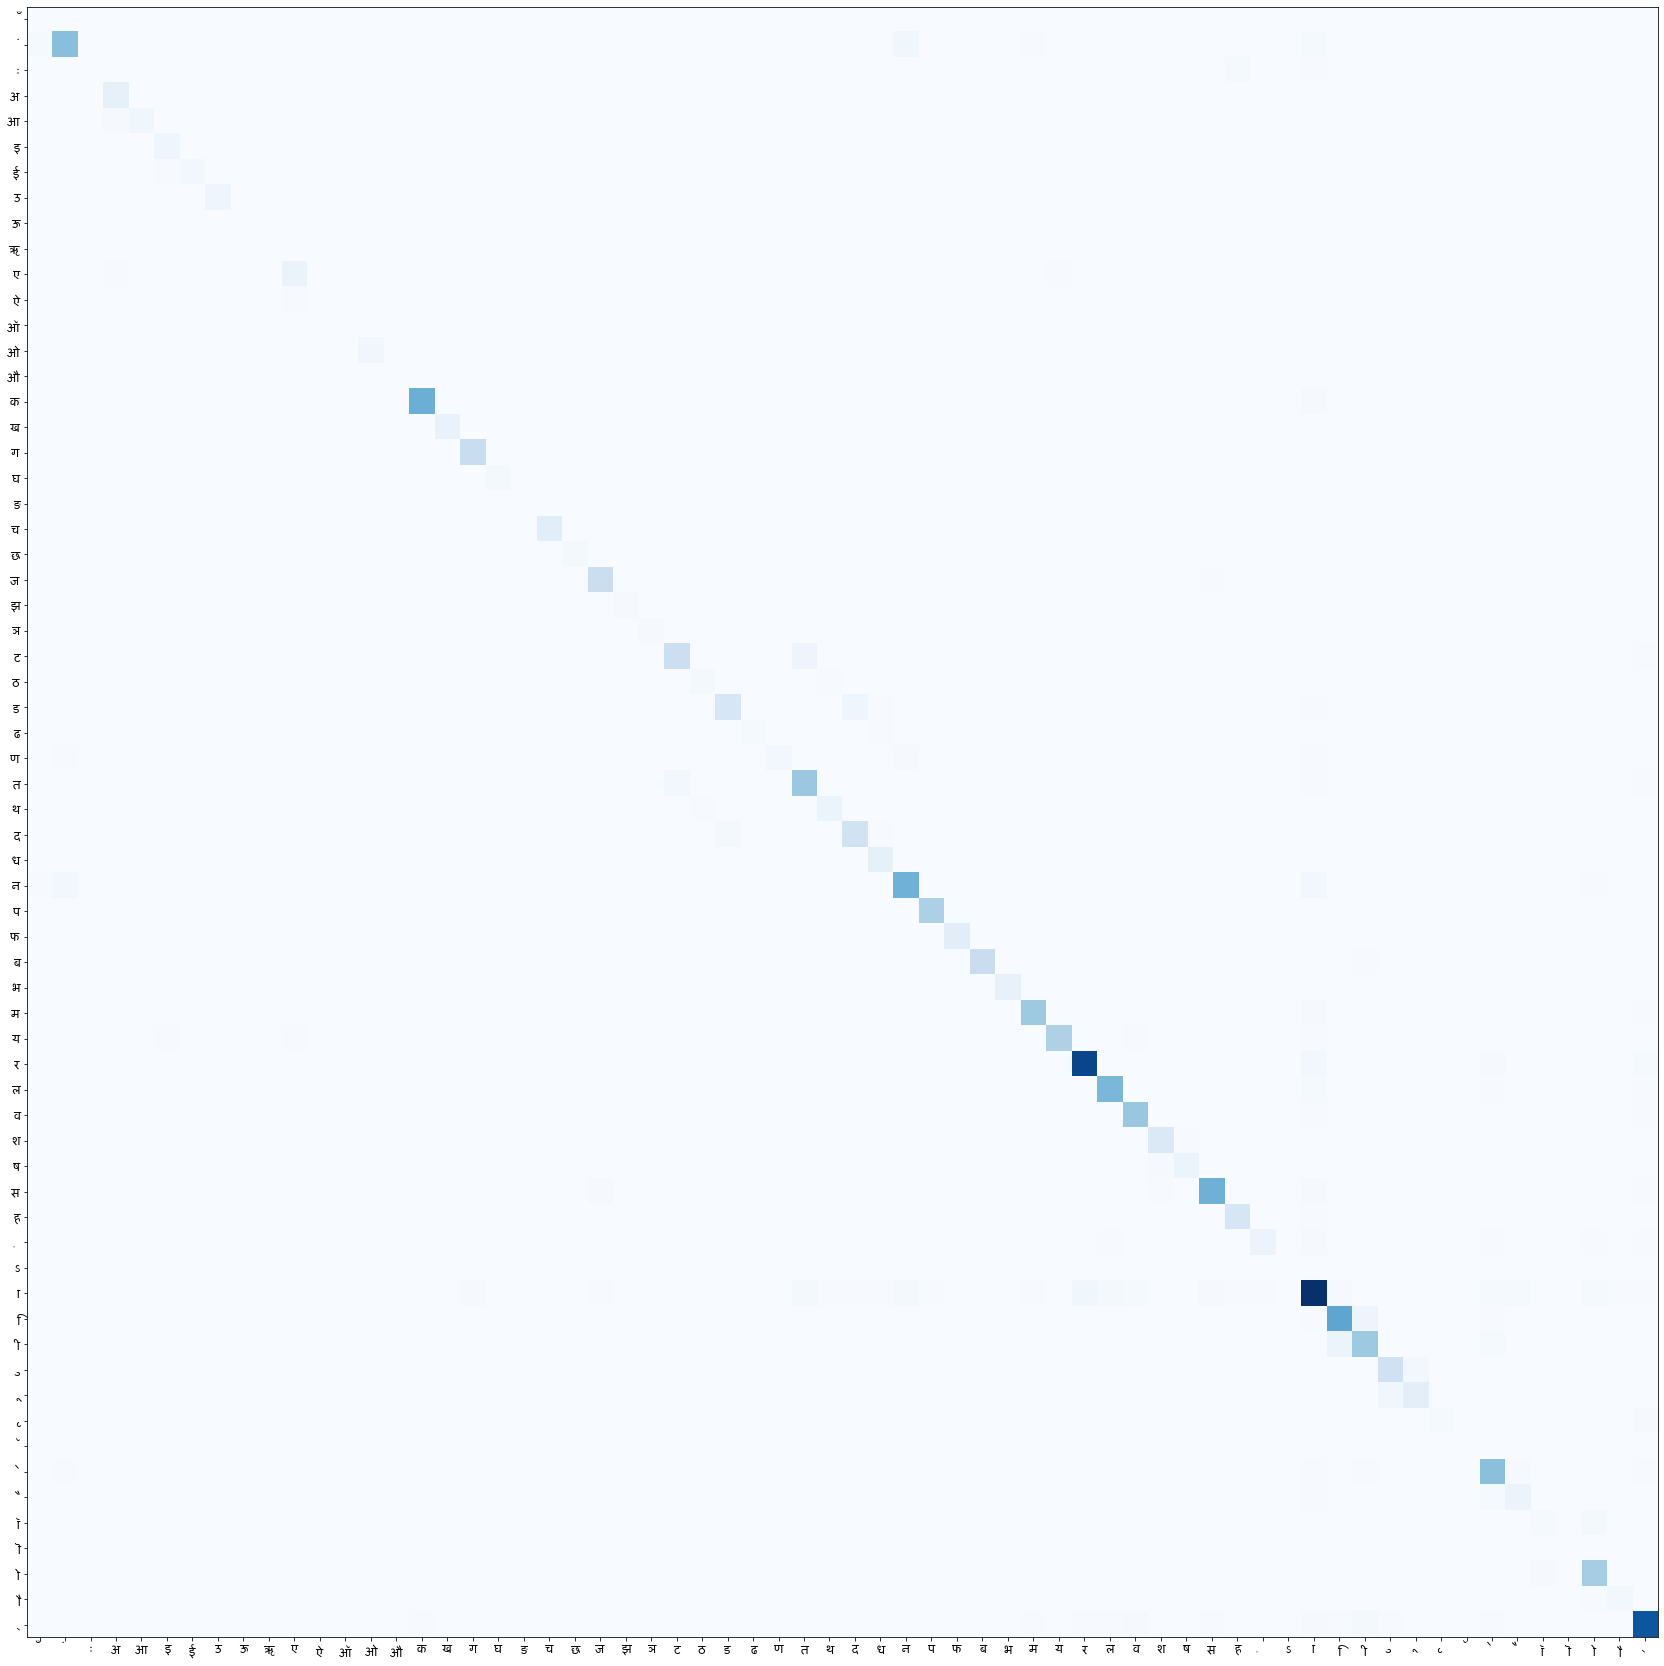

In [4]:
from viz import plot_confusion_matrix, plot_avg_error_vs_length

plot_confusion_matrix(y_pred1, y_true1)

c:\Users\palas\AppData\Local\Programs\Python\Python39\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 108 (l) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\palas\AppData\Local\Programs\Python\Python39\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 112 (p) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


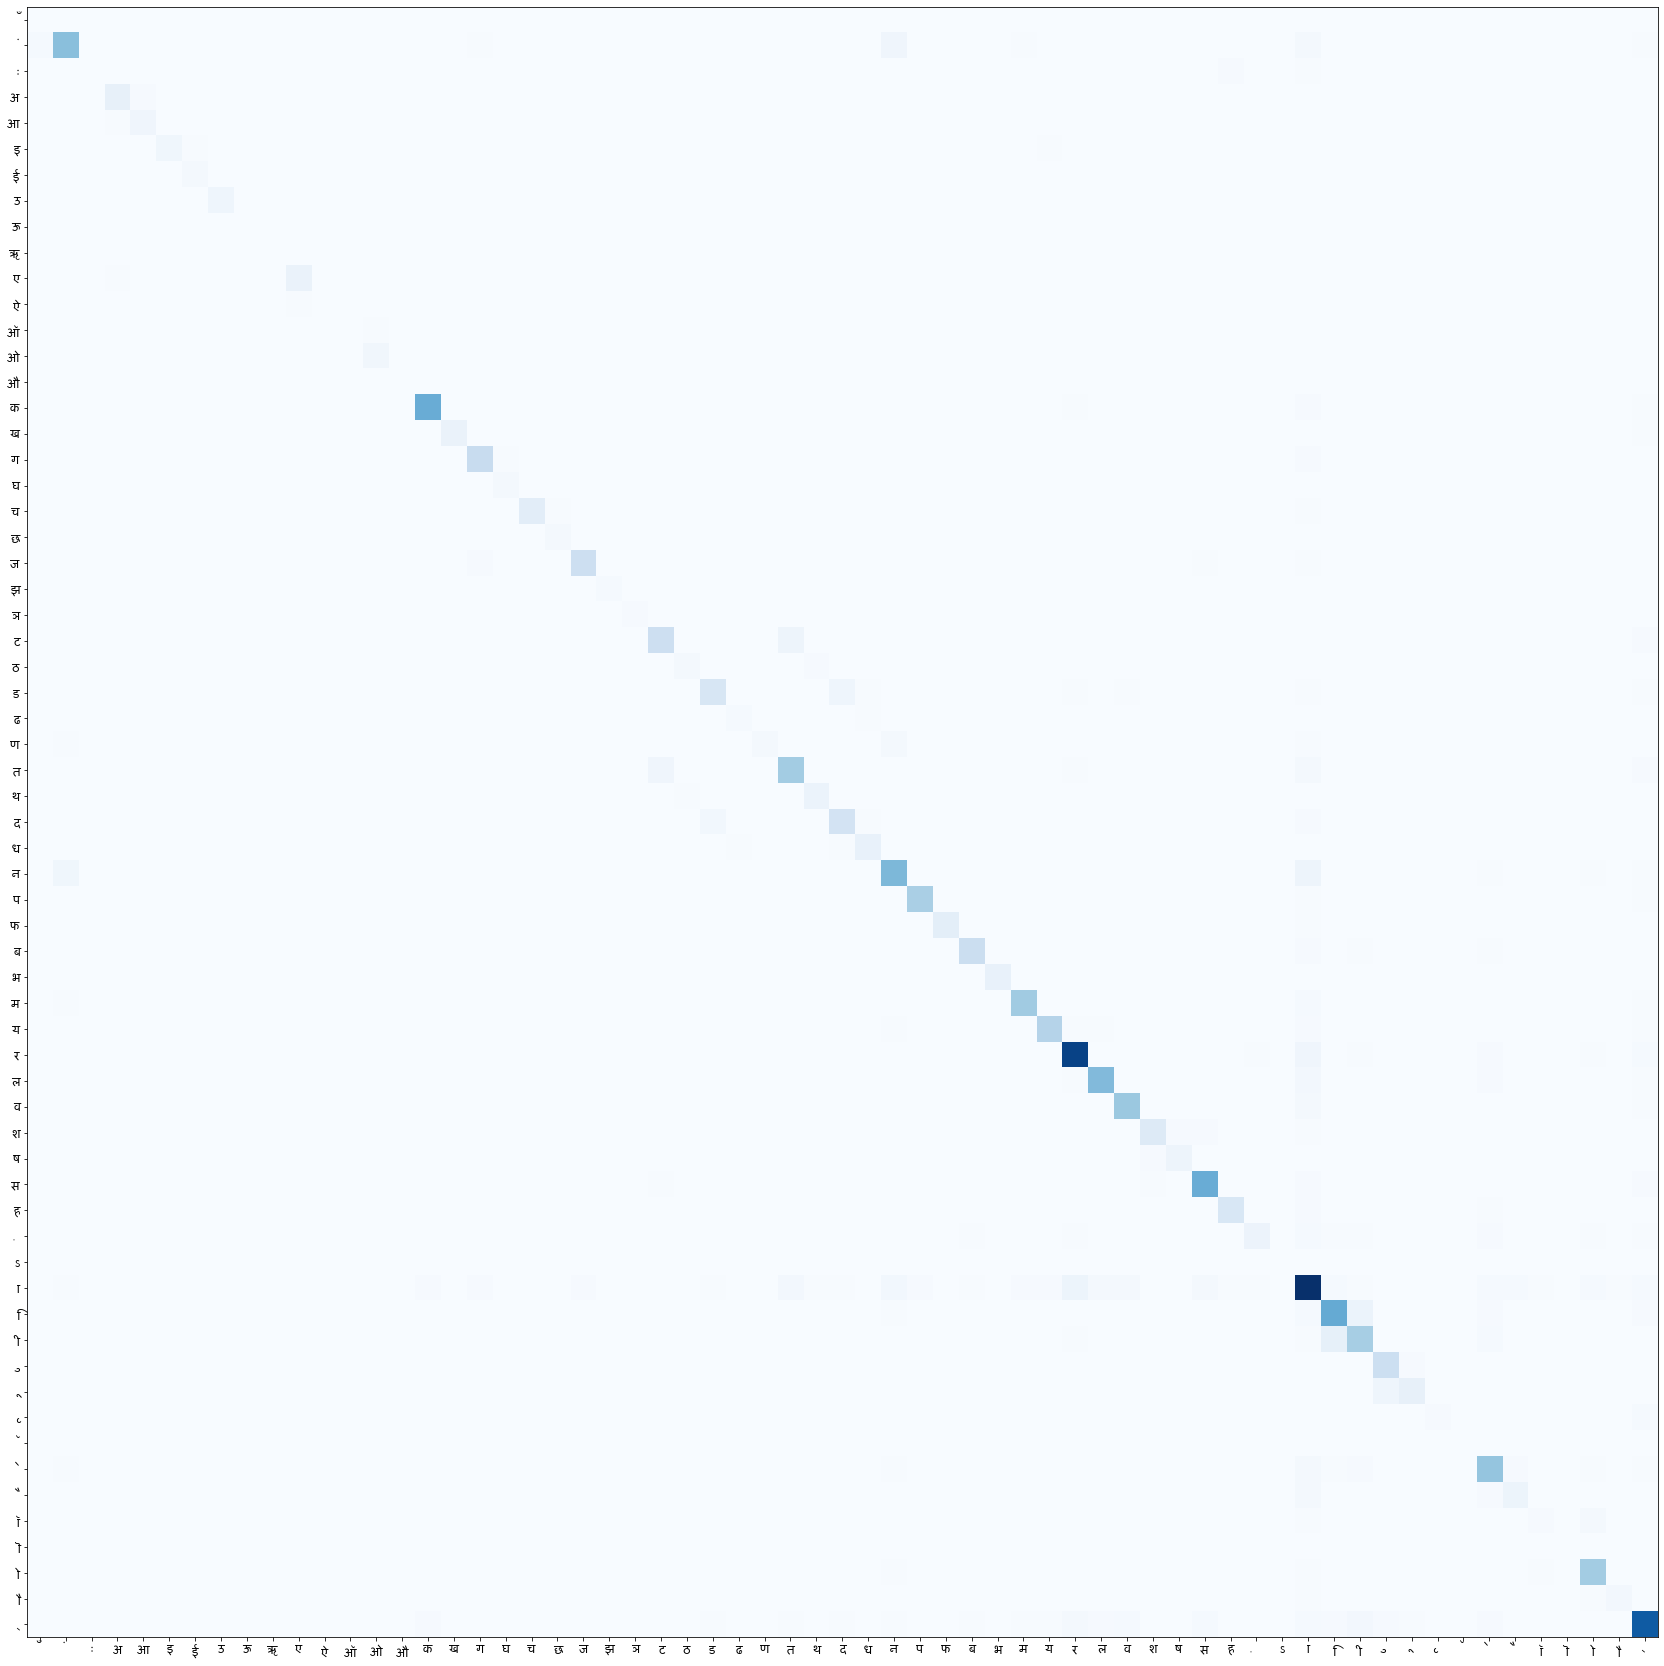

In [5]:
plot_confusion_matrix(y_pred2, y_true2)

{7: 1.5186567164179106, 4: 0.8782608695652174, 8: 1.547945205479452, 11: 2.6267605633802815, 9: 1.7235494880546076, 5: 1.0568475452196382, 3: 1.0479041916167664, 6: 1.1670854271356783, 10: 1.9864864864864864, 12: 2.425, 14: 2.6136363636363638, 17: 4.428571428571429, 13: 2.6825396825396823, 15: 4.233333333333333, 2: 1.263157894736842, 19: 6.8, 16: 5.181818181818182, 1: 1.0, 18: 6.0, 20: 6.0}


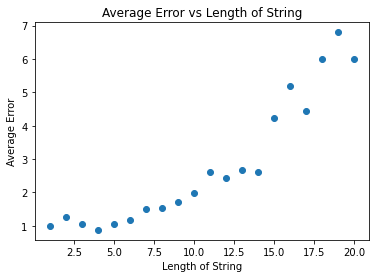

In [29]:
plot_avg_error_vs_length(predictions2, targets2)

In [30]:
import csv

def write_to_csv(strings, filename):

    with open(filename, 'w', encoding='utf-8', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerows([[string] for string in strings])  

write_to_csv(predictions1, 'vanilla_predictions//predictions_1')
write_to_csv(predictions2, 'vanilla_predictions//predictions_2')